# Synthetic Objective Testing Set (SOTS) Dataset

In [1]:
# Import necessary libraries
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from sots_dataset import SOTSDataset

In [2]:
# Define constants
DATASET_ROOT_DIR = './SOTS'
BATCH_SIZE = 32

In [3]:
# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [4]:
# Initialize the dataset for outdoor images
outdoor_dataset = SOTSDataset(root_dir=DATASET_ROOT_DIR, subset='outdoor', transform=image_transform)

# Initialize the dataset for indoor images
indoor_dataset = SOTSDataset(root_dir=DATASET_ROOT_DIR, subset='indoor', transform=image_transform)

Loaded 500 valid outdoor image pairs
Loaded 500 valid indoor image pairs


In [5]:
# Combine outdoor and indoor datasets
full_dataset = torch.utils.data.ConcatDataset([outdoor_dataset, indoor_dataset])

# Display the total number of samples in the full dataset
print(f"Total samples in full dataset: {len(full_dataset)}")

# Split the dataset into training and testing sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Display dataset split information
print(f"\nDataset split:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Test samples: {len(test_dataset)}")

Total samples in full dataset: 1000

Dataset split:
- Training samples: 800
- Test samples: 200


In [6]:
# Create data loaders for training and testing
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle directly in DataLoader
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [7]:
# Function to display sample images in a grid
def display_sample_images(dataset, num_samples=5):
    sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    
    for i, index in enumerate(sample_indices):
        hazy_image, clear_image = dataset[index]
        hazy_image = hazy_image.permute(1, 2, 0).numpy()
        clear_image = clear_image.permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(hazy_image)
        axes[i, 0].set_title('Hazy Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(clear_image)
        axes[i, 1].set_title('Clear Image')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

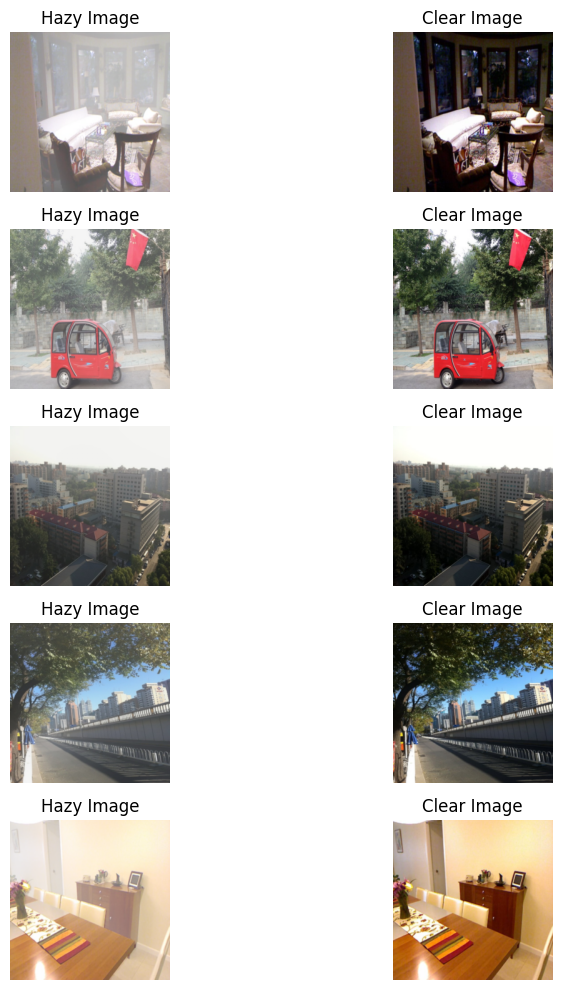

In [8]:
# Display sample images from the training dataset
display_sample_images(train_dataset, num_samples=5)